## Exploratory Data Analysis

### Imports and definitions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import albumentations
import albumentations.pytorch
import shap
import importlib
import mlflow
import preprocessing.crop_brain_region
import train_eval.loops
import train_eval.train
import train_eval.eval
import utils.data_collector
import utils.metrics
import utils.plots
import utils.mlflow
import utils.data_collector

#### Random seeds for reproducibility

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
sklearn.random.seed(0)

#### Set the device to run the models, GPU if it is available

In [3]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
cpu = torch.device("cpu")

#### Constants

In [4]:
IMAGE_SIZE = (224, 224)
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

mlflow.set_tracking_uri("sqlite:///mlflow.db")

#### Data collection and loading

Handled in [here](utils/data_collector.py)

To run this, it's needed to have kaggle.json from a kaggle key in ~/.kaggle folder

Alternatively, skip this part and manually download the dataset https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection in ./data folder and run the collector with should_download = False

In [9]:
collector = utils.data_collector.DataCollector(data_root_folder="data")
images, labels = collector.run(should_download=True)

Dataset URL: https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection


#### Visualizing images of each class

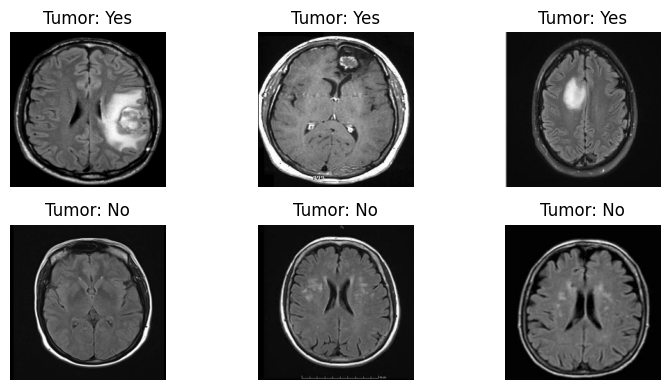

In [8]:
plt.figure(figsize=(8, 4))

for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[labels == 1][i + 10])
    plt.title("Tumor: Yes")
    plt.axis("off")

for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.imshow(images[labels == 0][i + 10])
    plt.title("Tumor: No")
    plt.axis("off")

plt.tight_layout()
plt.show()

#### Visualizing class distribution

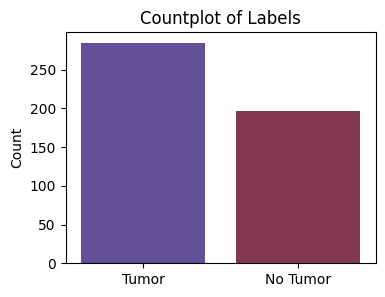

In [32]:
labels_nominal = np.where(labels == 0, "No Tumor", "Tumor")
plt.figure(figsize=(4, 3))
sns.countplot(x=labels_nominal, hue=labels_nominal, palette="twilight")
plt.title("Countplot of Labels")
plt.ylabel("Count")
plt.show()

### Data pre-processing

Using a custom transformation to crop the brain region, it is defined in [this python file](preprocessing/crop_brain_region.py) and it is possible to check its visual results in [this notebook](preprocessing/crop_brain_region_visualization.ipynb)

In [33]:
test_transform = albumentations.Compose(
    [
        preprocessing.crop_brain_region.CropBrainRegion(output_size=IMAGE_SIZE),
        albumentations.Normalize(mean=MEAN, std=STD),
        albumentations.pytorch.ToTensorV2(),
    ]
)

train_transform = albumentations.Compose(
    [
        preprocessing.crop_brain_region.CropBrainRegion(output_size=IMAGE_SIZE),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.5
        ),
        albumentations.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5
        ),
        albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        albumentations.GaussNoise(var_limit=(10, 50), p=0.5),
        albumentations.Normalize(mean=MEAN, std=STD),
        albumentations.pytorch.ToTensorV2(),
    ]
)

#### Data splitting

In [34]:
train_images, remaining_images, train_labels, remaining_labels = (
    sklearn.model_selection.train_test_split(
        images, labels, test_size=0.2, random_state=0
    )
)

val_images, test_images, val_labels, test_labels = (
    sklearn.model_selection.train_test_split(
        remaining_images, remaining_labels, test_size=0.5, random_state=0
    )
)

print("Train dataset size:", len(train_images))
print("Validation dataset size:", len(val_images))
print("Test dataset size:", len(test_images))

Train dataset size: 384
Validation dataset size: 48
Test dataset size: 48


#### Defining the dataset

In [35]:
class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label

In [36]:
train_dataset = BrainTumorDataset(train_images, train_labels, transform=train_transform)
val_dataset = BrainTumorDataset(val_images, val_labels, transform=test_transform)
test_dataset = BrainTumorDataset(test_images, test_labels, transform=test_transform)

batch_size = 8
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

### Baseline CNN

Baseline CNN model, for exploratory data analysis

In [37]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128 * 26 * 26, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)
model.to(device)
optim = torch.optim.Adam(model.parameters())

print("{:,}".format(sum(p.numel() for p in model.parameters())))

11,169,089


#### Train and evaluation of baseline CNN

2024/07/16 19:28:39 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/16 19:28:39 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
100%|██████████| 5/5 [00:51<00:00, 10.25s/it, Train Loss=0.676, Validation Loss=0.563, Validation Accuracy=0.646]


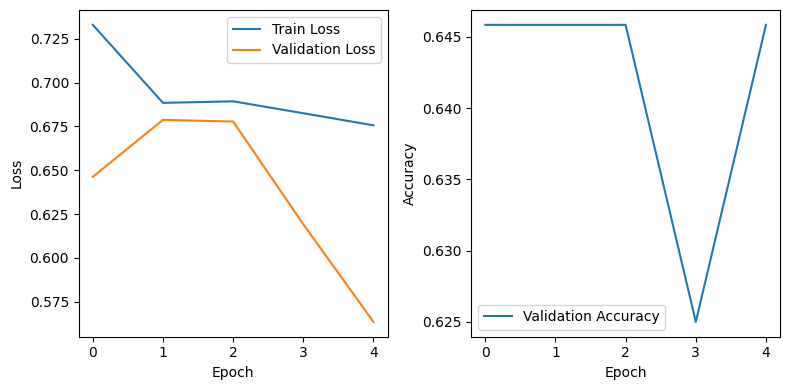

           Validation      Test
Accuracy     0.645833  0.541667
Precision    0.645833  0.541667
Recall       1.000000  1.000000
F1-Score     0.784810  0.702703


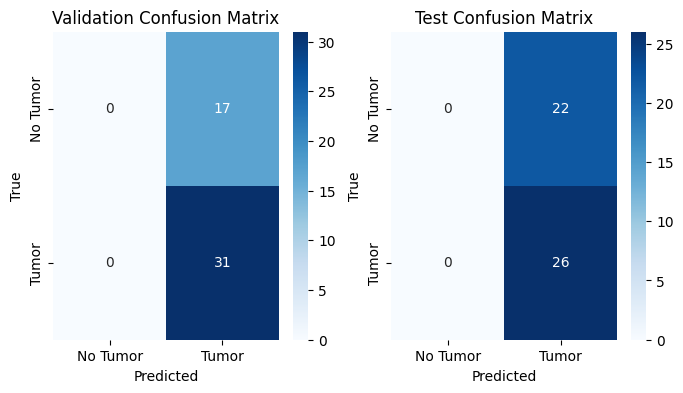

2024/07/16 19:29:36 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/16 19:29:36 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [38]:
importlib.reload(train_eval.loops)
importlib.reload(utils.plots)
importlib.reload(utils.mlflow)
importlib.reload(train_eval.train)
importlib.reload(train_eval.eval)

mlflow.set_experiment("Brain Tumor Detection - Model Training and Evaluation")

time_now = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M")

mlflow.start_run(run_name=f"baseline_cnn-{time_now}", log_system_metrics=True)

run_id = mlflow.active_run().info.run_id

mlflow.log_param("training_type", "train-from-scratch")

num_epochs = 5

trainer = train_eval.train.ModelTrainer(
    model=model,
    optimizer=optim,
    criterion=nn.BCELoss(),
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=num_epochs,
    model_name="baseline_cnn",
    mlflow_logging=True,
    train_transform=train_transform,
    test_transform=test_transform,
    plot=True,
    extra_mlflow_params=[
        ("Training Type", "Train From Scratch"),
    ],
)
model = trainer.run()

evaluator = train_eval.eval.ModelEvaluator(
    model=model,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=nn.BCELoss(),
    device=device,
    mlflow_logging=True,
    plot=True,
)
evaluator.run()

mlflow.end_run()

### Shapley Values

/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection/.venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f'unrecognized nn.Module: {module_type}')


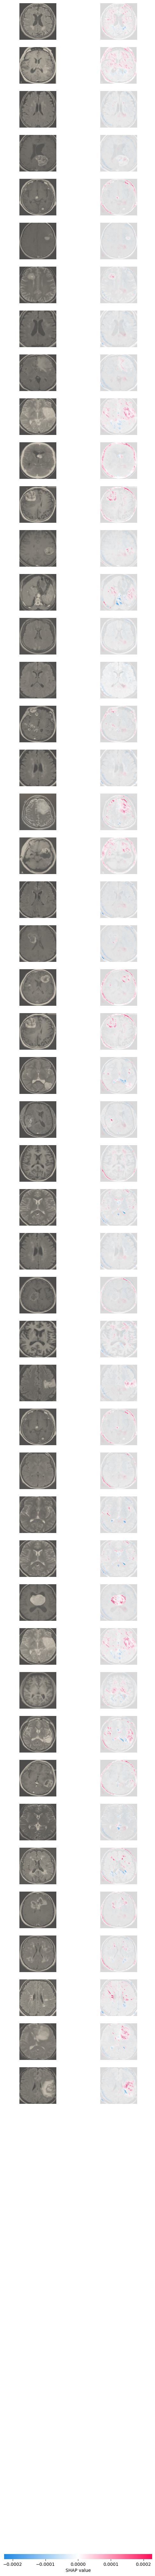

In [39]:
model.to("cpu")
model.eval()
test_loader_one_batch = torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0
)

# Get a batch of data for SHAP explainer
inputs, targets = next(iter(test_loader_one_batch))
inputs, targets = inputs.to("cpu"), targets.to("cpu")

# Initialize SHAP DeepExplainer with the model and a sample of the test data
explainer = shap.DeepExplainer(model, inputs)

# Change from NCHW to NHWC
inputs_numpy = inputs.permute(0, 2, 3, 1).numpy()

inputs_numpy = inputs_numpy * MEAN + STD

# Compute SHAP values for the test data
shap_values = explainer.shap_values(inputs)

shap_values_numpy = np.array(shap_values)
shap_values_numpy = shap_values_numpy.squeeze().transpose(0, 2, 3, 1)

# Undo the standardization
mean = np.array(MEAN).reshape(1, 1, 1, 3)
std = np.array(STD).reshape(1, 1, 1, 3)
inputs_numpy = inputs_numpy * std + mean

# Plot the SHAP values for the first image
shap.image_plot(shap_values_numpy, inputs_numpy)

### ResNet-18

In [40]:
resnet18 = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
)
resnet18.fc = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())

for name, param in resnet18.named_parameters():
    if "fc" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

optim_resnet18 = torch.optim.Adam(resnet18.parameters())
resnet18.to(device)
print()

In [41]:
mlflow.end_run()

2024/07/16 19:35:02 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/16 19:35:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
100%|██████████| 5/5 [00:47<00:00,  9.55s/it, Train Loss=0.51, Validation Loss=0.411, Validation Accuracy=0.854] 


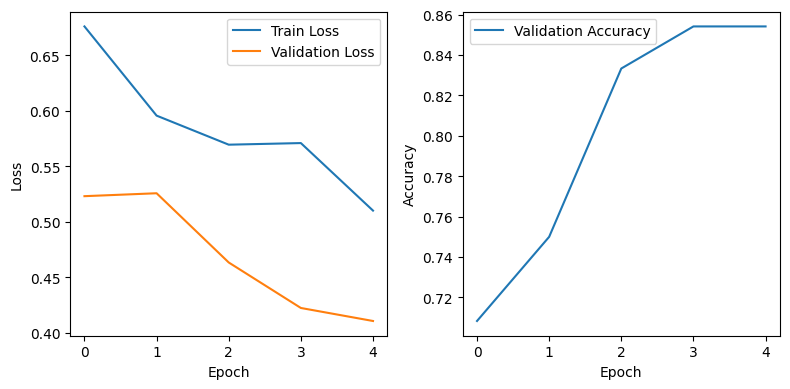

           Validation      Test
Accuracy     0.854167  0.875000
Precision    1.000000  0.833333
Recall       0.774194  0.961538
F1-Score     0.872727  0.892857


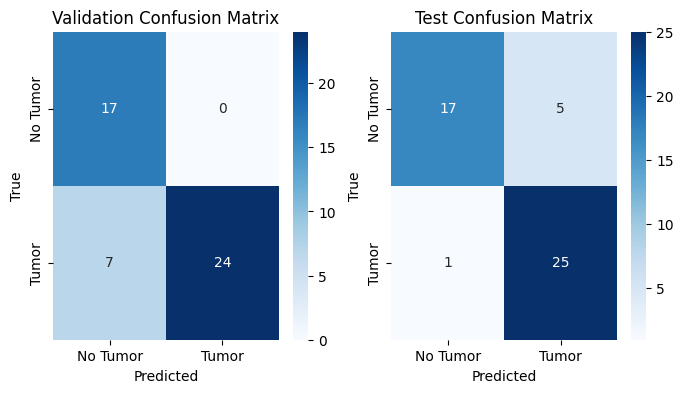

2024/07/16 19:35:54 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/16 19:35:54 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [42]:
importlib.reload(train_eval.loops)
importlib.reload(utils.plots)
importlib.reload(utils.mlflow)
importlib.reload(train_eval.train)
importlib.reload(train_eval.eval)


def epoch_finished_callback(epoch_number: int, model: nn.Module):
    if epoch_number == 20:
        for name, param in model.named_parameters():
            if "fc" not in name and "layer4" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

    if epoch_number == 60:
        for name, param in resnet18.named_parameters():
            if "fc" not in name and "layer4" not in name and "layer3" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True


mlflow.set_experiment("Brain Tumor Detection - Model Training and Evaluation")

time_now = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M")

mlflow.start_run(run_name=f"resnet18-{time_now}", log_system_metrics=True)

run_id = mlflow.active_run().info.run_id

num_epochs = 5

trainer = train_eval.train.ModelTrainer(
    model=resnet18,
    optimizer=optim_resnet18,
    criterion=nn.BCELoss(),
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=num_epochs,
    model_name="resnet18",
    mlflow_logging=True,
    train_transform=train_transform,
    test_transform=test_transform,
    plot=True,
    epoch_finished_callback=epoch_finished_callback,
    extra_mlflow_params=[
        ("Training Type", "Fine-Tuning"),
        (
            "Freezing Layers",
            {
                "Epochs 0-20": "All layers frozen except fc",
                "Epochs 21-60": "All layers frozen except fc and layer4",
                "Epochs 61-": "All layers frozen except fc, layer4 and layer3",
            },
        ),
    ],
)
model = trainer.run()

evaluator = train_eval.eval.ModelEvaluator(
    model=resnet18,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=nn.BCELoss(),
    device=device,
    mlflow_logging=True,
    plot=True,
)
evaluator.run()

mlflow.end_run()